<a href="https://colab.research.google.com/github/SohiniSur/Analysis-of-Child-Mortality-and-GDP-per-Capita/blob/main/Analysis_of_Child_Mortality_and_GDP_per_Capita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%markdown
# Nonlinear Smoothing Analysis of Child Mortality and GDP per Capita

This notebook performs a nonlinear smoothing analysis on the relationship between child mortality rate and GDP per capita using various methods including Kernel Smoother, LOESS, and K-Nearest Neighbors (KNN). The analysis involves data loading, preprocessing, splitting, cross-validation for hyperparameter tuning, model fitting, evaluation, and visualization.

First, we import the necessary Python libraries:
- `pandas` for data manipulation and analysis.
- `numpy` for numerical operations, especially array manipulation.
- `matplotlib.pyplot` for creating visualizations.
- `sklearn.model_selection.KFold` for cross-validation splitting.
- `sklearn.model_selection.train_test_split` for splitting data into training and testing sets.
- `sklearn.neighbors.KNeighborsRegressor` for the KNN regression model.
- `sklearn.metrics.mean_squared_error` and `mean_absolute_error` for model evaluation.
- `statsmodels.nonparametric.smoothers_lowess.lowess` for LOESS smoothing.
- `statsmodels.nonparametric.kernel_regression.KernelReg` for kernel regression (though Gaussian filter is used in the CV part, `KernelReg` is imported).
- `warnings` to ignore potential warning messages.

# Nonlinear Smoothing Analysis of Child Mortality and GDP per Capita

This notebook performs a nonlinear smoothing analysis on the relationship between child mortality rate and GDP per capita using various methods including Kernel Smoother, LOESS, and K-Nearest Neighbors (KNN). The analysis involves data loading, preprocessing, splitting, cross-validation for hyperparameter tuning, model fitting, evaluation, and visualization.

First, we import the necessary Python libraries:
- `pandas` for data manipulation and analysis.
- `numpy` for numerical operations, especially array manipulation.
- `matplotlib.pyplot` for creating visualizations.
- `sklearn.model_selection.KFold` for cross-validation splitting.
- `sklearn.model_selection.train_test_split` for splitting data into training and testing sets.
- `sklearn.neighbors.KNeighborsRegressor` for the KNN regression model.
- `sklearn.metrics.mean_squared_error` and `mean_absolute_error` for model evaluation.
- `statsmodels.nonparametric.smoothers_lowess.lowess` for LOESS smoothing.
- `statsmodels.nonparametric.kernel_regression.KernelReg` for kernel regression (though Gaussian filter is used in the CV part, `KernelReg` is imported).
- `warnings` to ignore potential warning messages.


In [4]:


import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.nonparametric.kernel_regression import KernelReg
import warnings
warnings.filterwarnings("ignore")



In [ ]:
%%markdown
## Data Loading

The dataset containing child mortality rates and GDP per capita is loaded from a CSV file into a pandas DataFrame. This DataFrame will be the basis for our analysis.

## Data Loading

The dataset containing child mortality rates and GDP per capita is loaded from a CSV file into a pandas DataFrame. This DataFrame will be the basis for our analysis.


In [5]:

csv_path = "child-mortality-gdp-per-capita.csv"
df = pd.read_csv(csv_path)
df.head()

,Entity,Code,Year,Child mortality rate,GDP per capita,900793-annotations,Population (historical),World regions according to OWID
0,Afghanistan,AFG,1957,37.13,1253.0,NaN,8588340.0,NaN
1,Afghanistan,AFG,1958,36.52,1298.0,NaN,8723412.0,NaN
2,Afghanistan,AFG,1959,35.95,1307.0,NaN,8869270.0,NaN
3,Afghanistan,AFG,1960,35.32,1326.0,NaN,9035048.0,NaN
4,Afghanistan,AFG,1961,34.76,1309.0,NaN,9214082.0,NaN


In [ ]:
%%markdown
## Data Preprocessing

### Variable Selection and Transformation

We select the 'Child mortality rate' and 'GDP per capita' columns for our analysis. As indicated in the assignment and common practice for skewed economic and mortality data, we apply a natural logarithm transformation to both variables. This helps to stabilize the variance and make the relationship more linear, which can improve the performance of smoothing methods.

## Data Preprocessing

### Variable Selection and Transformation

We select the 'Child mortality rate' and 'GDP per capita' columns for our analysis. As indicated in the assignment and common practice for skewed economic and mortality data, we apply a natural logarithm transformation to both variables. This helps to stabilize the variance and make the relationship more linear, which can improve the performance of smoothing methods.


In [6]:
x_col = "GDP per capita"
y_col= "Child mortality rate"

df[x_col] = np.log(df[x_col])
df[y_col] = np.log(df[y_col])

data = df[[x_col, y_col]].copy()

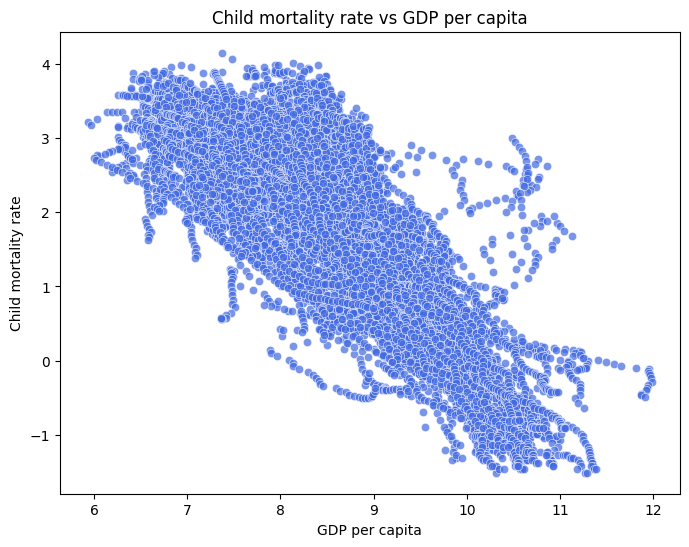

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Seaborn automatically handles nice sizing, colors, and gridlines
sns.scatterplot(
    data=data,
    x=x_col,
    y=y_col,
    color='royalblue',
    alpha=0.7
)

plt.title(f"{y_col} vs {x_col}")
plt.show()

In [ ]:
%%markdown
### Handling Missing Values

Before proceeding with the analysis, we need to address missing values in the dataset. We first check the number of rows in the DataFrame to see the initial size of our data after selecting the relevant columns and applying the log transformation.

### Handling Missing Values

Before proceeding with the analysis, we need to address missing values in the dataset. We first check the number of rows in the DataFrame to see the initial size of our data after selecting the relevant columns and applying the log transformation.


In [8]:
len(data)

63264

In [ ]:
%%markdown
Now, we remove any rows that contain missing values (`NaN`) in either the 'Child mortality rate' or 'GDP per capita' columns. This ensures that our analysis is performed on complete data points.

Now, we remove any rows that contain missing values (`NaN`) in either the 'Child mortality rate' or 'GDP per capita' columns. This ensures that our analysis is performed on complete data points.


In [9]:
data=data.dropna()

In [ ]:
%%markdown
After removing the rows with missing values, we check the number of remaining rows to understand the extent of data loss due to missingness.

After removing the rows with missing values, we check the number of remaining rows to understand the extent of data loss due to missingness.


In [10]:
len(data)

12672

In [ ]:
%%markdown
### Outlier Removal

Outliers can significantly affect the results of smoothing methods. We will use the Interquartile Range (IQR) method to identify and remove outliers from both the 'Child mortality rate' and 'GDP per capita' columns. The IQR method defines outliers as data points that fall below $Q1 - 1.5 \times IQR$ or above $Q3 + 1.5 \times IQR$, where $Q1$ is the first quartile, $Q3$ is the third quartile, and $IQR = Q3 - Q1$.

The following code cell defines a function `remove_iqr_outliers` to perform this task.

### Outlier Removal

Outliers can significantly affect the results of smoothing methods. We will use the Interquartile Range (IQR) method to identify and remove outliers from both the 'Child mortality rate' and 'GDP per capita' columns. The IQR method defines outliers as data points that fall below $Q1 - 1.5 \times IQR$ or above $Q3 + 1.5 \times IQR$, where $Q1$ is the first quartile, $Q3$ is the third quartile, and $IQR = Q3 - Q1$.

The following code cell defines a function `remove_iqr_outliers` to perform this task.


In [11]:
# IQR outlier removal
def remove_iqr_outliers(df_in, cols):
    df = df_in.copy()
    mask = np.ones(len(df), dtype=bool)
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        mask &= (df[c] >= lower) & (df[c] <= upper)
    return df[mask]



In [ ]:
%%markdown
We apply the `remove_iqr_outliers` function to the 'Child mortality rate' and 'GDP per capita' columns of our data. This step helps to ensure that extreme values do not disproportionately influence the smoothing models. We also reset the index of the DataFrame after removing rows.

We apply the `remove_iqr_outliers` function to the 'Child mortality rate' and 'GDP per capita' columns of our data. This step helps to ensure that extreme values do not disproportionately influence the smoothing models. We also reset the index of the DataFrame after removing rows.


In [12]:
before = len(data)
data = remove_iqr_outliers(data, [x_col, y_col]).reset_index(drop=True)
after = len(data)

In [13]:
print(before)
print(after)

12672
12662


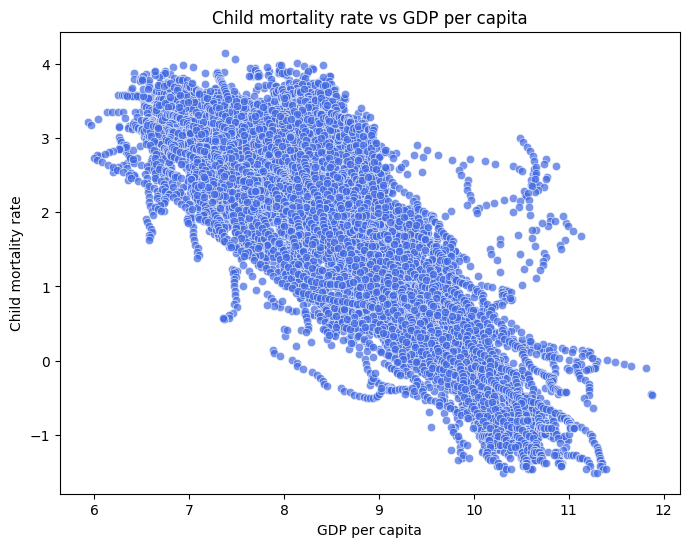

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Seaborn automatically handles nice sizing, colors, and gridlines
sns.scatterplot(
    data=data,
    x=x_col,
    y=y_col,
    color='royalblue',
    alpha=0.7
)

plt.title(f"{y_col} vs {x_col}")
plt.show()

In [ ]:
%%markdown
## Data Splitting

To evaluate the performance of our smoothing models in an unbiased way, we split the dataset into a training set and a testing set.

- The **training set** (`X_train`, `y_train`) will be used to train the models and to perform cross-validation for hyperparameter tuning.
- The **testing set** (`X_test`, `y_test`) will be held out and used only for the final evaluation of the best-performing models. This provides an unbiased estimate of how well the models generalize to unseen data.

We use a standard split ratio of 80% for training and 20% for testing. To ensure reproducibility, a `random_state` is set.
- `X_train`: Training data for the feature (Child mortality rate).
- `y_train`: Training data for the target variable (GDP per capita).
- `X_test`: Testing data for the feature.
- `y_test`: Testing data for the target variable.

## Data Splitting

To evaluate the performance of our smoothing models in an unbiased way, we split the dataset into a training set and a testing set.

- The **training set** (`X_train`, `y_train`) will be used to train the models and to perform cross-validation for hyperparameter tuning.
- The **testing set** (`X_test`, `y_test`) will be held out and used only for the final evaluation of the best-performing models. This provides an unbiased estimate of how well the models generalize to unseen data.

We use a standard split ratio of 80% for training and 20% for testing. To ensure reproducibility, a `random_state` is set.
- `X_train`: Training data for the feature (Child mortality rate).
- `y_train`: Training data for the target variable (GDP per capita).
- `X_test`: Testing data for the feature.
- `y_test`: Testing data for the target variable.


In [ ]:
# Split
seed = 1
np.random.seed(seed)
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
X_train = train_df[x_col].values; y_train = train_df[y_col].values
X_test = test_df[x_col].values; y_test = test_df[y_col].values

In [ ]:
%%markdown
## Cross-Validation for Hyperparameter Tuning

Cross-validation is a crucial technique for evaluating the performance of a model and selecting the best hyperparameters without overfitting to the training data. It involves partitioning the training data into multiple folds. The model is trained on a subset of these folds and evaluated on the remaining fold. This process is repeated multiple times, with each fold serving as the validation set exactly once. The performance metrics (like MSE and MAE) are averaged across all folds to provide a more robust estimate of the model's performance for a given set of hyperparameters.

### KFold Setup

We are using K-Fold cross-validation with $k=5$ splits. This means the training data is divided into 5 equal-sized folds. In each iteration of the cross-validation, 4 folds are used for training the model, and the remaining 1 fold is used for validation. This is repeated 5 times, with a different fold used for validation in each iteration.

We chose $k=5$ as it offers a good balance between bias and variance in the performance estimate and computational cost. With a training dataset size of approximately 10,000 samples, $k=5$ results in reasonably sized training and validation sets in each fold (around 8,000 for training and 2,000 for validation), providing a stable estimate of performance.

### Hyperparameter Ranges

For each smoothing method, we define a range of hyperparameters to explore during cross-validation:

- **Kernel Smoother (Gaussian Filter):** The hyperparameter is the `bandwidth` (`sigma` in `gaussian_filter1d`). This controls the width of the Gaussian kernel and thus the degree of smoothing. A larger bandwidth results in more smoothing. We explore a range of bandwidths from 0.5 to 25.
- **LOESS:** The hyperparameter is the `frac` (fraction). This determines the proportion of data points used for local regression at each point. A larger fraction results in a smoother fit. We explore a range of fractions from 0.05 to 1.0.
- **KNN:** The hyperparameter is `n_neighbors` (k). This is the number of nearest neighbors used to predict the value for a given point. A larger k results in a smoother but potentially less flexible fit. We explore a range of k values from 1 to 50 (specifically odd numbers in this range to avoid ties in distance).

### Cross-Validation Process

For each smoothing method, we iterate through the defined range of hyperparameters. For each hyperparameter value, we perform the K-Fold cross-validation:

1. **Splitting Data:** The training data (`X_train`, `y_train`) is split into $k$ training and validation folds using `kf.split()`.
2. **Training:** The smoothing model is trained on the data from the training folds. For Kernel Smoother and LOESS, this involves sorting the training fold data and applying the smoothing function. For KNN, the `KNeighborsRegressor` model is fitted to the training fold data.
3. **Prediction:** The trained model is used to make predictions on the data from the validation fold. For Kernel Smoother and LOESS, this is done using interpolation based on the smoothed training data. For KNN, the `predict` method is used.
4. **Evaluation:** The Mean Squared Error (MSE) and Mean Absolute Error (MAE) are calculated by comparing the predicted values to the actual values in the validation fold.
5. **Averaging:** After iterating through all $k$ folds, the MSE and MAE scores from each fold are averaged to get the average cross-validation MSE and MAE for that specific hyperparameter value.

These average MSE and MAE scores for each hyperparameter value are stored in the `results` dictionary, categorized by the smoothing method. This allows us to compare the performance of different hyperparameter values and identify the optimal ones.

## Cross-Validation for Hyperparameter Tuning

Cross-validation is a crucial technique for evaluating the performance of a model and selecting the best hyperparameters without overfitting to the training data. It involves partitioning the training data into multiple folds. The model is trained on a subset of these folds and evaluated on the remaining fold. This process is repeated multiple times, with each fold serving as the validation set exactly once. The performance metrics (like MSE and MAE) are averaged across all folds to provide a more robust estimate of the model's performance for a given set of hyperparameters.

### KFold Setup

We are using K-Fold cross-validation with $k=5$ splits. This means the training data is divided into 5 equal-sized folds. In each iteration of the cross-validation, 4 folds are used for training the model, and the remaining 1 fold is used for validation. This is repeated 5 times, with a different fold used for validation in each iteration.

We chose $k=5$ as it offers a good balance between bias and variance in the performance estimate and computational cost. With a training dataset size of approximately 10,000 samples, $k=5$ results in reasonably sized training and validation sets in each fold (around 8,000 for training and 2,000 for validation), providing a stable estimate of performance.

### Hyperparameter Ranges

For each smoothing method, we define a range of hyperparameters to explore during cross-validation:

- **Kernel Smoother (Gaussian Filter):** The hyperparameter is the `bandwidth` (`sigma` in `gaussian_filter1d`). This controls the width of the Gaussian kernel and thus the degree of smoothing. A larger bandwidth results in more smoothing. We explore a range of bandwidths from 0.5 to 25.
- **LOESS:** The hyperparameter is the `frac` (fraction). This determines the proportion of data points used for local regression at each point. A larger fraction results in a smoother fit. We explore a range of fractions from 0.05 to 1.0.
- **KNN:** The hyperparameter is `n_neighbors` (k). This is the number of nearest neighbors used to predict the value for a given point. A larger k results in a smoother but potentially less flexible fit. We explore a range of k values from 1 to 50 (specifically odd numbers in this range to avoid ties in distance).

### Cross-Validation Process

For each smoothing method, we iterate through the defined range of hyperparameters. For each hyperparameter value, we perform the K-Fold cross-validation:

1. **Splitting Data:** The training data (`X_train`, `y_train`) is split into $k$ training and validation folds using `kf.split()`.
2. **Training:** The smoothing model is trained on the data from the training folds. For Kernel Smoother and LOESS, this involves sorting the training fold data and applying the smoothing function. For KNN, the `KNeighborsRegressor` model is fitted to the training fold data.
3. **Prediction:** The trained model is used to make predictions on the data from the validation fold. For Kernel Smoother and LOESS, this is done using interpolation based on the smoothed training data. For KNN, the `predict` method is used.
4. **Evaluation:** The Mean Squared Error (MSE) and Mean Absolute Error (MAE) are calculated by comparing the predicted values to the actual values in the validation fold.
5. **Averaging:** After iterating through all $k$ folds, the MSE and MAE scores from each fold are averaged to get the average cross-validation MSE and MAE for that specific hyperparameter value.

These average MSE and MAE scores for each hyperparameter value are stored in the `results` dictionary, categorized by the smoothing method. This allows us to compare the performance of different hyperparameter values and identify the optimal ones.


In [ ]:
%%markdown
## Finding Optimal Hyperparameters and Visualizing Results

After performing cross-validation for each smoothing method across their respective hyperparameter ranges, we identify the "optimal" hyperparameter value. The optimal hyperparameter is typically chosen as the value that results in the lowest average cross-validation error. We primarily use Mean Squared Error (MSE) as the metric for determining the optimal hyperparameter, but we also consider Mean Absolute Error (MAE).

The following code block first identifies the optimal hyperparameters based on the minimum average MSE from the cross-validation results for each method (Kernel Smoother, LOESS, and KNN).

Then, it generates plots to visualize the relationship between the hyperparameter values and the average cross-validation errors (both MSE and MAE) for each smoothing method. These plots are essential for understanding:

- How sensitive each smoothing method is to its hyperparameter choice.
- The range of hyperparameters that yield good performance.
- Whether there is a clear minimum error, indicating a well-defined optimal hyperparameter.

Each plot shows the average CV_MSE and CV_MAE on the y-axis and the corresponding hyperparameter values on the x-axis. The optimal hyperparameter value (based on the lowest average MSE and MAE) is highlighted on the plots with a distinct marker to visually indicate the chosen best values.

## Finding Optimal Hyperparameters and Visualizing Results

After performing cross-validation for each smoothing method across their respective hyperparameter ranges, we identify the "optimal" hyperparameter value. The optimal hyperparameter is typically chosen as the value that results in the lowest average cross-validation error. We primarily use Mean Squared Error (MSE) as the metric for determining the optimal hyperparameter, but we also consider Mean Absolute Error (MAE).

The following code block first identifies the optimal hyperparameters based on the minimum average MSE from the cross-validation results for each method (Kernel Smoother, LOESS, and KNN).

Then, it generates plots to visualize the relationship between the hyperparameter values and the average cross-validation errors (both MSE and MAE) for each smoothing method. These plots are essential for understanding:

- How sensitive each smoothing method is to its hyperparameter choice.
- The range of hyperparameters that yield good performance.
- Whether there is a clear minimum error, indicating a well-defined optimal hyperparameter.

Each plot shows the average CV_MSE and CV_MAE on the y-axis and the corresponding hyperparameter values on the x-axis. The optimal hyperparameter value (based on the lowest average MSE and MAE) is highlighted on the plots with a distinct marker to visually indicate the chosen best values.



Performing Cross-Validation for Kernel Smoother (Gaussian Filter)...

Performing Cross-Validation for LOESS...

Performing Cross-Validation for KNN...

Finding optimal hyperparameters and plotting results...


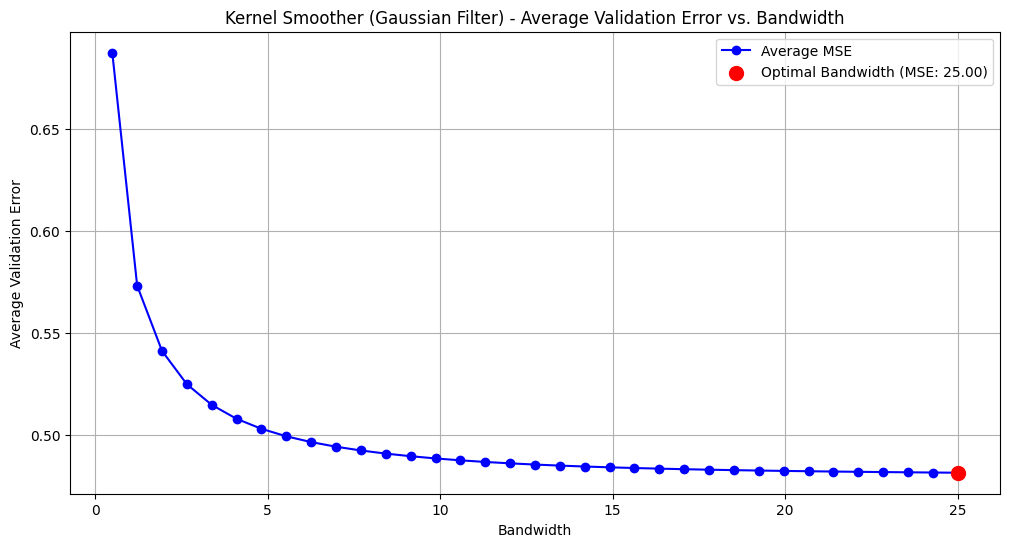

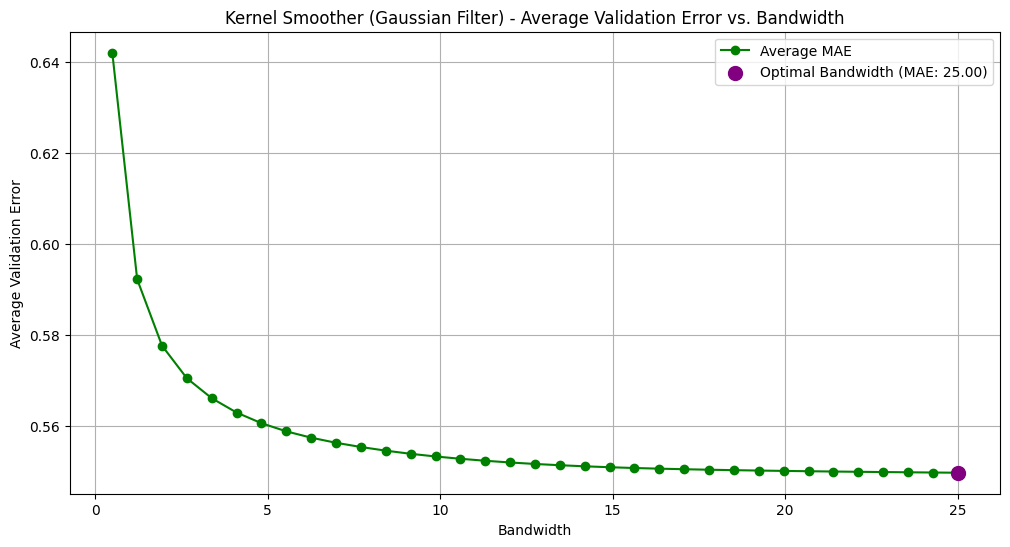

Optimal Bandwidth for Kernel Smoother (Gaussian Filter) (based on lowest average MSE): 25.00
Optimal Bandwidth for Kernel Smoother (Gaussian Filter) (based on lowest average MAE): 25.00


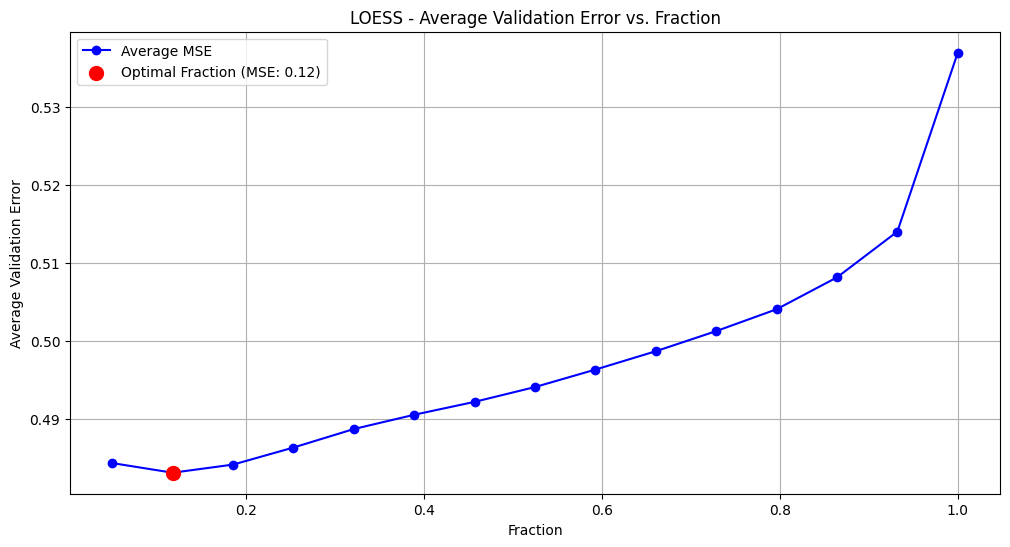

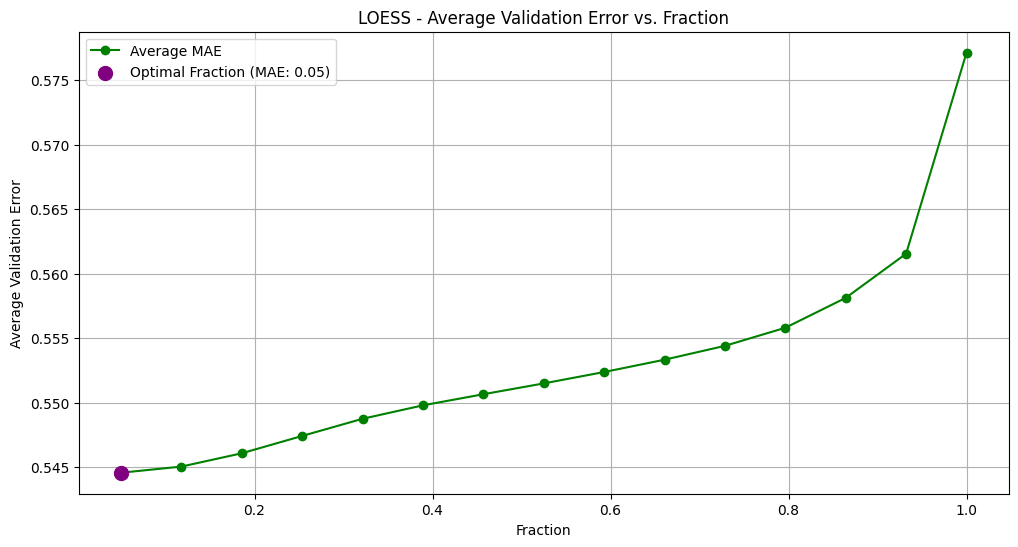

Optimal Fraction for LOESS (based on lowest average MSE): 0.12
Optimal Fraction for LOESS (based on lowest average MAE): 0.05


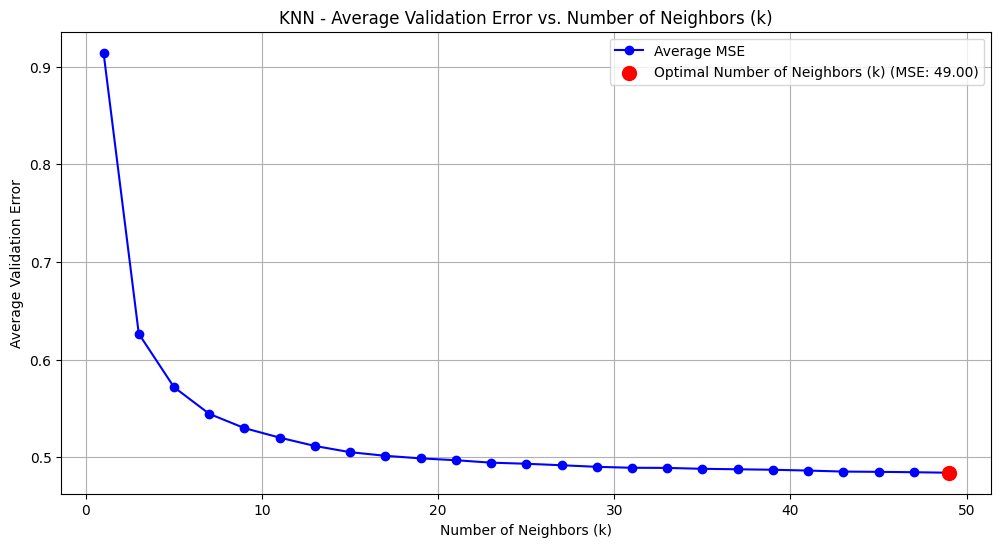

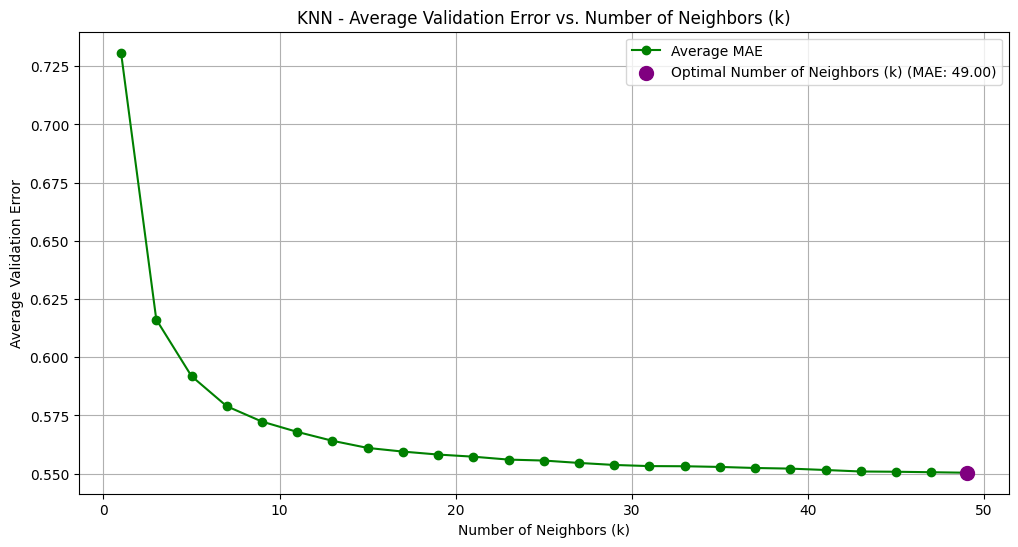

Optimal Number of Neighbors (k) for KNN (based on lowest average MSE): 49.00
Optimal Number of Neighbors (k) for KNN (based on lowest average MAE): 49.00

Justification for choice of k:
We chose k = 5 for k-fold cross-validation.
With a training dataset size of 10129, a value of k=5 means that in each fold, 8103 samples are used for training and 2026 samples are used for validation.
This value of k provides a good balance between bias and variance in the estimation of the model's performance.
A larger k (e.g., 10) would provide a less biased estimate of performance but at the cost of increased computational time and potentially higher variance if the number of samples per fold becomes very small.
A smaller k (e.g., 2 or 3) would be computationally faster but could lead to a more biased estimate of performance as the training folds are smaller.
Given the dataset size, k=5 offers a reasonable compromise.


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.neighbors import KNeighborsRegressor

# Choose a reasonable k for cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define hyperparameter ranges

kernel_bandwidth_range = np.linspace(0.5, 25, 35) # Bandwidth for Gaussian Kernel Smoother
loess_frac_range = np.linspace(0.05, 1.0, 15) # Fraction of data points for LOESS
knn_k_range = range(1, 51, 2) # Range for k in KNN

results = {}



# Kernel Smoother Cross-Validation (using Gaussian Filter)
print("\nPerforming Cross-Validation for Kernel Smoother (Gaussian Filter)...")
kernel_results = {'mse': [], 'mae': []}
for bandwidth in kernel_bandwidth_range:
    mse_scores = []
    mae_scores = []
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Sort data for smoothing
        sort_indices_train = np.argsort(X_train_fold.flatten())
        sorted_X_train_fold = X_train_fold[sort_indices_train].flatten()
        sorted_y_train_fold = y_train_fold[sort_indices_train]

        # Apply Gaussian filter
        smoothed_y_train_fold = gaussian_filter1d(sorted_y_train_fold, sigma=bandwidth)

        # Interpolate to predict on validation set
        smoothed_y_val_fold = np.interp(X_val_fold.flatten(), sorted_X_train_fold, smoothed_y_train_fold)

        mse = mean_squared_error(y_val_fold, smoothed_y_val_fold)
        mae = mean_absolute_error(y_val_fold, smoothed_y_val_fold)
        mse_scores.append(mse)
        mae_scores.append(mae)

    kernel_results['mse'].append(np.nanmean(mse_scores))
    kernel_results['mae'].append(np.nanmean(mae_scores))
results['kernel_smoother'] = kernel_results

# LOESS Cross-Validation
print("\nPerforming Cross-Validation for LOESS...")
loess_results = {'mse': [], 'mae': []}
for frac in loess_frac_range:
    mse_scores = []
    mae_scores = []
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index] # Corrected typo here

        # Ensure enough data points for LOESS with the current fraction
        if len(X_train_fold) > 1 and int(frac * len(X_train_fold)) > 1:
            # Use lowess for LOESS smoothing
            # Sort data for lowess function
            sort_indices_train = np.argsort(X_train_fold.flatten())
            sorted_X_train_fold = X_train_fold[sort_indices_train].flatten()
            sorted_y_train_fold = y_train_fold[sort_indices_train]

            smoothed_train_data = sm.nonparametric.lowess(sorted_y_train_fold, sorted_X_train_fold, frac=frac)
            # The output of lowess is sorted by x values, so we need to interpolate to predict on validation set
            smoothed_y_val_fold = np.interp(X_val_fold.flatten(), smoothed_train_data[:, 0], smoothed_train_data[:, 1])

            mse = mean_squared_error(y_val_fold, smoothed_y_val_fold)
            mae = mean_absolute_error(y_val_fold, smoothed_y_val_fold)
            mse_scores.append(mse)
            mae_scores.append(mae)
        else:
             mse_scores.append(np.nan)
             mae_scores.append(np.nan)


    loess_results['mse'].append(np.nanmean(mse_scores))
    loess_results['mae'].append(np.nanmean(mae_scores))
results['loess'] = loess_results

# KNN Cross-Validation
print("\nPerforming Cross-Validation for KNN...")
knn_results = {'mse': [], 'mae': []}
for k_val in knn_k_range:
    mse_scores = []
    mae_scores = []
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        knn = KNeighborsRegressor(n_neighbors=k_val)
        knn.fit(X_train_fold.reshape(-1, 1), y_train_fold)
        y_pred_val = knn.predict(X_val_fold.reshape(-1, 1))

        mse = mean_squared_error(y_val_fold, y_pred_val)
        mae = mean_absolute_error(y_val_fold, y_pred_val)
        mse_scores.append(mse)
        mae_scores.append(mae)

    knn_results['mse'].append(np.nanmean(mse_scores))
    knn_results['mae'].append(np.nanmean(mae_scores))
results['knn'] = knn_results


# Find optimal hyperparameters and plot results
print("\nFinding optimal hyperparameters and plotting results...")

def plot_cv_results(hyperparameter_range, mse_scores, mae_scores, param_name, method_name):
    """Plots cross-validation results and marks optimal hyperparameter."""
    plt.figure(figsize=(12, 6))

    # Plot MSE
    plt.plot(hyperparameter_range, mse_scores, marker='o', linestyle='-', color='blue', label='Average MSE')
    min_mse_index = np.nanargmin(mse_scores)
    plt.scatter(hyperparameter_range[min_mse_index], mse_scores[min_mse_index], color='red', s=100, label=f'Optimal {param_name} (MSE: {hyperparameter_range[min_mse_index]:.2f})', zorder=5)

    plt.xlabel(param_name)
    plt.ylabel('Average Validation Error')
    plt.title(f'{method_name} - Average Validation Error vs. {param_name}')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
     # Plot MAE
    plt.plot(hyperparameter_range, mae_scores, marker='o', linestyle='-', color='green', label='Average MAE')
    min_mae_index = np.nanargmin(mae_scores)
    plt.scatter(hyperparameter_range[min_mae_index], mae_scores[min_mae_index], color='purple', s=100, label=f'Optimal {param_name} (MAE: {hyperparameter_range[min_mae_index]:.2f})', zorder=5)

    plt.xlabel(param_name)
    plt.ylabel('Average Validation Error')
    plt.title(f'{method_name} - Average Validation Error vs. {param_name}')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Determine optimal hyperparameter (using MSE as the primary metric)
    optimal_param_mse = hyperparameter_range[min_mse_index]
    optimal_param_mae = hyperparameter_range[min_mae_index]
    print(f"Optimal {param_name} for {method_name} (based on lowest average MSE): {optimal_param_mse:.2f}")
    print(f"Optimal {param_name} for {method_name} (based on lowest average MAE): {optimal_param_mae:.2f}")


# Plot results for each method

plot_cv_results(list(kernel_bandwidth_range), results['kernel_smoother']['mse'], results['kernel_smoother']['mae'], 'Bandwidth', 'Kernel Smoother (Gaussian Filter)')
plot_cv_results(list(loess_frac_range), results['loess']['mse'], results['loess']['mae'], 'Fraction', 'LOESS')
plot_cv_results(list(knn_k_range), results['knn']['mse'], results['knn']['mae'], 'Number of Neighbors (k)', 'KNN') # Added plotting for KNN

print("\nJustification for choice of k:")
print(f"We chose k = {k} for k-fold cross-validation.")
print(f"With a training dataset size of {len(X_train)}, a value of k=5 means that in each fold, {len(X_train) * (k-1)/k:.0f} samples are used for training and {len(X_train)/k:.0f} samples are used for validation.")
print("This value of k provides a good balance between bias and variance in the estimation of the model's performance.")
print("A larger k (e.g., 10) would provide a less biased estimate of performance but at the cost of increased computational time and potentially higher variance if the number of samples per fold becomes very small.")
print("A smaller k (e.g., 2 or 3) would be computationally faster but could lead to a more biased estimate of performance as the training folds are smaller.")
print("Given the dataset size, k=5 offers a reasonable compromise.")

In [ ]:
%%markdown
## Final Model Fitting and Evaluation

Having identified the optimal hyperparameters for each smoothing method through cross-validation, we now fit the final models using these best parameters on the *entire* training dataset (`X_train` and `y_train`). This step utilizes all available training data to build the most robust model possible with the chosen hyperparameters.

- **Kernel Smoother (Gaussian Filter):** The Gaussian filter is applied to the sorted entire training data using the optimal bandwidth.
- **LOESS:** The `lowess` function is applied to the sorted entire training data using the optimal fraction.
- **KNN:** The `KNeighborsRegressor` model is fitted to the entire training data using the optimal number of neighbors (`k`).

Once the models are trained on the full training set, they are then evaluated on the unseen test dataset (`X_test` and `y_test`). This evaluation provides an unbiased estimate of how well each smoothing method, with its optimal hyperparameters, is expected to perform on new, unseen data. The Mean Squared Error (MSE) is calculated for each model on the test set to compare their performance.

## Final Model Fitting and Evaluation

Having identified the optimal hyperparameters for each smoothing method through cross-validation, we now fit the final models using these best parameters on the *entire* training dataset (`X_train` and `y_train`). This step utilizes all available training data to build the most robust model possible with the chosen hyperparameters.

- **Kernel Smoother (Gaussian Filter):** The Gaussian filter is applied to the sorted entire training data using the optimal bandwidth.
- **LOESS:** The `lowess` function is applied to the sorted entire training data using the optimal fraction.
- **KNN:** The `KNeighborsRegressor` model is fitted to the entire training data using the optimal number of neighbors (`k`).

Once the models are trained on the full training set, they are then evaluated on the unseen test dataset (`X_test` and `y_test`). This evaluation provides an unbiased estimate of how well each smoothing method, with its optimal hyperparameters, is expected to perform on new, unseen data. The Mean Squared Error (MSE) is calculated for each model on the test set to compare their performance.


In [ ]:
# 1. Define optimal hyperparameters (based on lowest average MSE from previous step)

optimal_bandwidth = kernel_bandwidth_range[np.nanargmin(results['kernel_smoother']['mse'])]
optimal_frac = loess_frac_range[np.nanargmin(results['loess']['mse'])]
optimal_k_knn = knn_k_range[np.nanargmin(results['knn']['mse'])]

#print(f"Optimal Bins for Bin Smoother: {optimal_bins}")
print(f"Optimal Bandwidth for Kernel Smoother: {optimal_bandwidth:.2f}")
print(f"Optimal Fraction for LOESS: {optimal_frac:.2f}")
print(f"Optimal Number of Neighbors (k) for KNN: {optimal_k_knn}")


# 2. Fit and Evaluate Kernel Smoother (Gaussian Filter)
print("\nFitting and Evaluating Kernel Smoother (Gaussian Filter)...")
# Sort data for smoothing
sort_indices_train_kernel = np.argsort(X_train.flatten())
sorted_X_train_kernel = X_train[sort_indices_train_kernel].flatten()
sorted_y_train_kernel = y_train[sort_indices_train_kernel]

# Apply Gaussian filter to the entire training data
smoothed_y_train_kernel = gaussian_filter1d(sorted_y_train_kernel, sigma=optimal_bandwidth)

# Predict on test set using interpolation
y_pred_kernel = np.interp(X_test.flatten(), sorted_X_train_kernel, smoothed_y_train_kernel)

# Compute Test MSE for Kernel Smoother
test_mse_kernel = mean_squared_error(y_test, y_pred_kernel)
print(f"Kernel Smoother Test MSE: {test_mse_kernel:.4f}")

# 3. Fit and Evaluate LOESS
print("\nFitting and Evaluating LOESS...")
# Sort data for lowess function
sort_indices_train_loess = np.argsort(X_train.flatten())
sorted_X_train_loess = X_train[sort_indices_train_loess].flatten()
sorted_y_train_loess = y_train[sort_indices_train_loess]

# Fit LOESS on entire training data
# Check if enough data points for LOESS
if len(X_train) > 1 and int(optimal_frac * len(X_train)) > 1:
    smoothed_train_data_loess = sm.nonparametric.lowess(sorted_y_train_loess, sorted_X_train_loess, frac=optimal_frac)

    # Predict on test set using interpolation
    y_pred_loess = np.interp(X_test.flatten(), smoothed_train_data_loess[:, 0], smoothed_train_data_loess[:, 1])

    # Compute Test MSE for LOESS
    test_mse_loess = mean_squared_error(y_test, y_pred_loess)
    print(f"LOESS Test MSE: {test_mse_loess:.4f}")
else:
    test_mse_loess = np.nan
    print("Could not fit LOESS model with optimal fraction on training data (not enough points).")

# 4. Fit and Evaluate KNN
print("\nFitting and Evaluating KNN...")
# Fit KNN on entire training data
knn = KNeighborsRegressor(n_neighbors=optimal_k_knn)
knn.fit(X_train.reshape(-1, 1), y_train)

# Predict on test set
y_pred_knn = knn.predict(X_test.reshape(-1, 1))

# Compute Test MSE for KNN
test_mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"KNN Test MSE: {test_mse_knn:.4f}")


# Store Test MSE results
test_mse_results = {
    'Kernel Smoother': test_mse_kernel,
    'LOESS': test_mse_loess,
    'KNN': test_mse_knn # Add KNN results
}

print("\nTest MSE Results:")
for method, mse in test_mse_results.items():
    print(f"{method}: {mse:.4f}")

Optimal Bandwidth for Kernel Smoother: 25.00
Optimal Fraction for LOESS: 0.12
Optimal Number of Neighbors (k) for KNN: 49

Fitting and Evaluating Kernel Smoother (Gaussian Filter)...
Kernel Smoother Test MSE: 0.4807

Fitting and Evaluating LOESS...
LOESS Test MSE: 0.4772

Fitting and Evaluating KNN...
KNN Test MSE: 0.4857

Test MSE Results:
Kernel Smoother: 0.4807
LOESS: 0.4772
KNN: 0.4857


COMPARISON TABLE

In [ ]:
# Create a DataFrame to compare the performance of the smoothing methods
# Includes optimal hyperparameters, best cross-validation MSE, and test set MSE.
comparison_df_corrected = pd.DataFrame({
    'Method': ['Kernel Smoother', 'LOESS', 'KNN'],
    'Best Parameter': [optimal_bandwidth, optimal_frac, optimal_k_knn],
    'Best CV_MSE': [min(kernel_results['mse']), min(loess_results['mse']), min(knn_results['mse'])],
    'Test_MSE': [test_mse_kernel, test_mse_loess, test_mse_knn]
})
display(comparison_df_corrected)

,Method,Best Parameter,Best CV_MSE,Test_MSE
0,Kernel Smoother,25.000000,0.481232,0.480729
1,LOESS,0.117857,0.483123,0.477234
2,KNN,49.000000,0.484041,0.485668


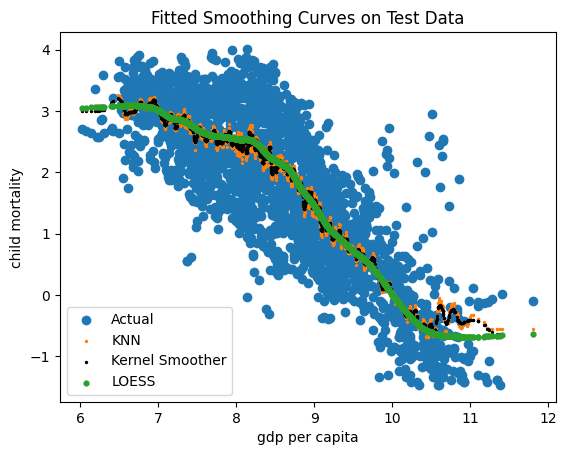

In [ ]:
plt.scatter(X_test,y_test, label='Actual')
plt.plot(X_test,y_pred_knn, label='KNN', )
plt.plot(X_test,y_pred_kernel, color='black', label='Kernel Smoother', )
plt.plot(X_test,y_pred_loess, label='LOESS', )

plt.legend()
plt.xlabel('gdp per capita')
plt.ylabel('child mortality')
plt.title('Fitted Smoothing Curves on Test Data')
plt.show()